Notebook to do a MNIST-neural network from scratch based on the data provide by YannLecun http://yann.lecun.com/exdb/mnist/ (see also the paper "Deep learning" by Yann LeCun1, Yoshua Bengio & Geoffrey Hinton in NATURE, VOL 521, 28 MAY 201) and the tutorial https://github.com/numpy/numpy-tutorials/blob/main/content/tutorial-deep-learning-on-mnist.md


In [1]:
import gzip
import os
import numpy as np
import pandas as pd
import matplotlib as plt

In [2]:
files={"test_images":"t10k-images-idx3-ubyte.gz",
        "test_labels":"t10k-labels-idx1-ubyte.gz",
        "train_images":"train-images-idx3-ubyte.gz",
     "train_labels":"train-labels-idx1-ubyte.gz"}

In [3]:
mnist_dataset = {}
# Images
for key in ("train_images", "test_images"):
    with gzip.open(os.path.join("", files[key]), "rb") as mnist_file:
        mnist_dataset[key] = np.frombuffer(
            mnist_file.read(), np.uint8, offset=16
        ).reshape(-1, 28 * 28)
# Labels
for key in ("train_labels", "test_labels"):
    with gzip.open(os.path.join("", files[key]), "rb") as mnist_file:
        mnist_dataset[key] = np.frombuffer(mnist_file.read(), np.uint8, offset=8)

In [4]:
# We store the data into training and test set
x_train, y_train, x_test, y_test = (
    mnist_dataset["train_images"],
    mnist_dataset["train_labels"],
    mnist_dataset["test_images"],
    mnist_dataset["test_labels"],
)

In [5]:
print("x_train.shape= ",x_train.shape)
print("y_train.shape= ",y_train.shape)

x_train.shape=  (60000, 784)
y_train.shape=  (60000,)


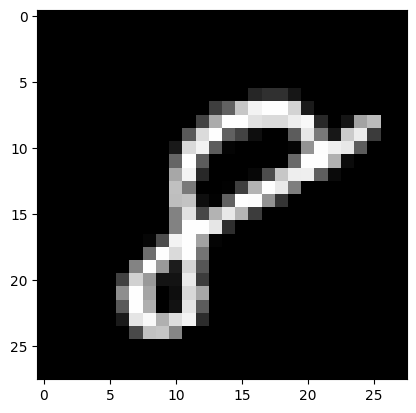

In [6]:
import matplotlib.pyplot as plt
# Take the 60,000th image (indexed at 59,999) from the training set,
# reshape from (784, ) to (28, 28) to have a valid shape for displaying purposes.
mnist_image = x_train[59999, :].reshape(28, 28)
# Set the color mapping to grayscale to have a black background.
plt.imshow(mnist_image, cmap="gray")
# Display the image.
plt.show()

In [7]:
print("The data type of training images: {}".format(x_train.dtype))
print("The data type of test images: {}".format(x_test.dtype))

The data type of training images: uint8
The data type of test images: uint8


In [8]:
training_sample, test_sample = 1000, 1000
training_images = x_train[0:training_sample] / 255
test_images = x_test[0:test_sample] / 255

In [9]:
print("The data type of training images: {}".format(training_images.dtype))
print("The data type of test images: {}".format(test_images.dtype))

The data type of training images: float64
The data type of test images: float64


In [10]:
def one_hot_encoding(labels, dimension=10):
    # Define a one-hot variable for an all-zero vector
    # with 10 dimensions (number labels from 0 to 9).
    one_hot_labels = labels[..., None] == np.arange(dimension)[None]
    # Return one-hot encoded labels.
    return one_hot_labels.astype(np.float64)

In [11]:
training_labels = one_hot_encoding(y_train[:training_sample])
test_labels = one_hot_encoding(y_test[:test_sample])

In [12]:
print("The data type of training labels: {}".format(training_labels.dtype))
print("The data type of test labels: {}".format(test_labels.dtype))

The data type of training labels: float64
The data type of test labels: float64


In [13]:
print([i for i in range(10)])
print("---------------- label ----------------")
print(training_labels[0])
print(training_labels[1])
print(training_labels[2])
print("---------------- original ----------------")
print(y_train[0])
print(y_train[1])
print(y_train[2])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
---------------- label ----------------
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
---------------- original ----------------
5
0
4


## Network Architecture

Architecture of the ANN:  
one input layer of 784 nodes 
Two hidden layer:  
   - one of 28x28 =392 nodes
   - one of 98
   (or 196 if trying with a third - one of 28)
   
one output layer of 10 nodes  (one for each number)

## Forward propagation

As the network is a multilayer perceptron for a multiclass classification problem, we use a leaky ReLU activation function in the first hidden layer then a swish activation function in the second hidden layer and a softmax activation function in the final layer. 

We choose sofmax in the last layer because it's the layer with the less node hence it's not very important if this function is a little heavy computing due to the exponential.


## Activation function

In [22]:
leaky_relu = lambda x : np.maximum(0.1*x,x)
relu = lambda x :  np.maximum(0.,x)
#sigmoid = lambda x : 1./(1.+np.exp(-x+max(x))) 
def sigmoid( x ):
    # Prevent overflow.
    x = np.clip( x, -500, 500 )
    return 1.0/( 1.0 + np.exp( -x ))

swish = lambda x : (x-max(x))*sigmoid(x) # in case of need of omprovement, could use x*sigma_swish(beta*x) 
softmax = lambda x :np.exp(x-max(x))/np.sum(np.exp(x-max(x))) 

## Backward activation

To give our network the ability to learn we define optimizers.

First we define a loss function. We use softmax as final activation function hence we use the categorical cross entropy 
$ CSE = \sum_i^n (-y_i log(\hat y_i) + (1-y_i)(-log(1 -\hat y_i)))$ where $ \hat y_i $ is the predicted value and n the number of classes and $n$ is the number of class. (see https://developers.google.com/machine-learning/crash-course/logistic-regression/model-training)

In [32]:
#tab store the list of couple [y_true, y_prev]
#cse  = lambda true,prev : sum([true[i][0]*(-np.log(prev[i][0]))+(1-true[i][0])*(-np.log(1 - prev[i][0])) for i in range(len(true))])   
def cse(X,Y):
    epsilon=1e-7
    loss=-np.sum(X *np.log(Y+epsilon))
    loss-=np.sum((1.0-X) * (np.log(1.0-Y+epsilon)))
    return loss

## Backward propagation

In [40]:
def categorical_cross_entropy_derivative(y_true, y_pred):
    num_samples = y_true.shape[0]
    # Avoid division by zero by clipping the predicted values
    y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
    # Compute the derivative of categorical cross entropy loss
    gradient = (-(y_true / y_pred_clipped) + (1-y_true) / (1-y_pred_clipped))/num_samples
    return gradient

In [47]:
def categorical_cross_entropy_derivative(y_true, y_pred):
    c = np.zeros((y_true.shape[0],1))
    for i in range(y_true.shape[0]):
        c[i][0]=-(y_true[i][0] / (y_pred[i][0] +1e-7) + (1-y_true[i][0]) / (1-y_pred[i][0]+1e-7))
    return c         

In [18]:
# derivatives of the activation function
backward_leaky_relu = lambda x: np.where(x > 0., 1., 0.1)
backward_relu = lambda x: (x > 0.) * 1
backward_swish = lambda x : (1. - sigmoid(x))*swish(x) + sigmoid(x) 

In [19]:
def backward_softmax(x):
    t=softmax(x)
    return np.array([[ t[i][0]*(1.-t[i][0]) if j==i else -t[i][0]*t[j][0] for j in range(t.shape[0]) ] for i in range(t.shape[0]) ])

## Training of the model

In [49]:
# To store training and test set losses and accurate predictions
# for visualization.
store_training_loss = []
store_training_accurate_pred = []
store_test_loss = []
store_test_accurate_pred = []

learning_rate = 0.001 # for gradient descent
epochs = 100 # number of iteration
hidden_size_1 = 392 
hidden_size_2 = 98
hidden_size_3 = 10 
pixels_per_image = 784

##We initialize the weights and bias. 
##Our network is fully connected so one node is linked to all nodes of the next layer
seed = 42
rng = np.random.default_rng(seed)
generate_weight = lambda layer_1, layer_2 :0.2 * rng.random((layer_2,layer_1 )) - 0.1
weights_1 = generate_weight(pixels_per_image, hidden_size_1)
weights_2 = generate_weight(hidden_size_1, hidden_size_2)
weights_3 = generate_weight(hidden_size_2, hidden_size_3)
generate_bias = lambda layer_size :  0.05 * rng.random((layer_size,1))
bias_1 = generate_bias(hidden_size_1)
bias_2 = generate_bias(hidden_size_2)
bias_3 = generate_bias(hidden_size_3)
# This is a training loop.
# Run the learning experiment for a defined number of epochs (iterations).
print("start training")
in_layer = lambda ins, weights,bias : np.add(np.dot(weights,ins ),bias)
nb_pred=0
nb_iter=0
for i in range(epochs):
    training_loss=0.0
    training_accurate_pred = 0.0
    for j in range(len(training_images)):
        # get the input and output of nodes
        labels = training_labels[j].reshape(10,1)
        input_img=training_images[i].reshape(pixels_per_image,1)
        in_layer_1 = in_layer(input_img,weights_1,bias_1)
        out_layer_1 = relu(in_layer_1)
        in_layer_2 = in_layer(out_layer_1,weights_2,bias_2)
        #out_layer_2 = relu(in_layer_2)
        out_layer_2 = swish(in_layer_2)
        in_layer_3 = in_layer(out_layer_2,weights_3, bias_3)
        out_layer_3 = softmax(in_layer_3)
        #out_layer_3= sigmoid(in_layer_3)
        #get the loss
        training_loss += categorical_cross_entropy_derivative(labels,out_layer_3)
        
        #compute the derivative for back propagation
        # last layer
        print(backward_softmax(in_layer_3)[1][:3])
        print(categorical_cross_entropy_derivative(out_layer_3, labels)[1][:3])
        dz3 =  np.matmul(backward_softmax(in_layer_3),  categorical_cross_entropy_derivative(out_layer_3, labels))
        #dz3 = out_layer_3 - labels #case of sigmoid in last layer
        dw3 = dz3 * out_layer_2.T
        db3 = dz3.copy()
        #2nd layer
        dz2 = np.dot(weights_3.T, dz3)*backward_swish(in_layer_2)
        #dz2 = np.dot(weights_3.T, dz3)*backward_relu(in_layer_2)
        dw2 = dz2 * out_layer_1.T
        db2 = dz2.copy()
        #first layer
        dz1 = np.dot(weights_2.T, dz2)*backward_relu(in_layer_1)
        dw1 = dz1 * input_img.T
        db1 = dz1.copy()
        
        #update the weights
        #print("i = ",i,", j = ", j,", dw3[0][0] = ",dw3[0][0],", weights_3[0][0] = ",weights_3[0][0])
        weights_3 -= learning_rate * dw3
        #print("new weights_3[0][0] = ",weights_3[0][0])
        weights_2 -= learning_rate * dw2
        weights_1 -= learning_rate * dw1
        #update the bias
        bias_3 = bias_3 - learning_rate * db3
        bias_2 = bias_2 - learning_rate * db2
        bias_1 = bias_1 - learning_rate * db1
        print("------- out layer 1--------")
        print(out_layer_1[1])
        print("------- out layer 2--------")
        print(out_layer_2[1])
        print("------- out layer 3--------")
        print(out_layer_3[1])
        print("------- weight1--------")
        print(weights_1[1][:5])
        print("------- weight2--------")
        print(weights_2[1][:5])
        print("------- weight3--------")
        print(weights_3[1][:5])
        print("------- dw1--------")
        print(dw1[1][:5])
        print("------- dw2--------")
        print(dw2[1][:5])
        print("------- dw3--------")
        print(dw3[1][:5])
        break
        if j==len(training_images)-1:
            print( "pred ",out_layer_3.T, ", true ",labels.T)
        training_accurate_pred += int(np.argmax(out_layer_3) == np.argmax(labels))
        nb_iter+=1
    # Store training set losses and accurate predictions.
    #break
    store_training_loss.append(training_loss)
    store_training_accurate_pred.append(training_accurate_pred)
print("training loss",store_training_loss)
print("accurate_pred",store_training_accurate_pred)
print(nb_iter)

start training
[-0.01759896  0.13537253 -0.01485834]
[-1614332.97079951]
------- out layer 1--------
[0.85470814]
------- out layer 2--------
[-0.4779771]
------- out layer 3--------
[0.16143321]
------- weight1--------
[ 0.09692991 -0.02769278  0.06263187 -0.03632018  0.0598427 ]
------- weight2--------
[-8.43373876 -9.64669522 -0.06444096 -0.02731354  0.03251688]
------- weight3--------
[19.53071756 23.21328754 26.46260854 20.68470708 24.51769174]
------- dw1--------
[0. 0. 0. 0. 0.]
------- dw2--------
[8367.27189544 9640.26372361    0.            0.            0.        ]
------- dw3--------
[-19457.27946976 -23275.92078132 -26513.07379789 -20649.93323589
 -24450.75526162]
[-0.  0. -0.]
[-0.9999999]
------- out layer 1--------
[0.]
------- out layer 2--------
[-6.68841779e-212]
------- out layer 3--------
[0.]
------- weight1--------
[ 0.09692991 -0.02769278  0.06263187 -0.03632018  0.0598427 ]
------- weight2--------
[-8.43373876 -9.64669522 -0.06444096 -0.02731354  0.03251688]
--

------- out layer 1--------
[0.]
------- out layer 2--------
[-6.06950193e-212]
------- out layer 3--------
[0.]
------- weight1--------
[ 0.09692991 -0.02769278  0.06263187 -0.03632018  0.0598427 ]
------- weight2--------
[-8.43373876 -9.64669522 -0.06444096 -0.02731354  0.03251688]
------- weight3--------
[19.53071756 23.21328754 26.46260854 20.68470708 24.51769174]
------- dw1--------
[0. 0. 0. 0. 0.]
------- dw2--------
[-0. -0. -0. -0. -0.]
------- dw3--------
[0. 0. 0. 0. 0.]
[-0.  0. -0.]
[-0.9999999]
------- out layer 1--------
[0.]
------- out layer 2--------
[-3.6141673e-212]
------- out layer 3--------
[0.]
------- weight1--------
[ 0.09692991 -0.02769278  0.06263187 -0.03632018  0.0598427 ]
------- weight2--------
[-8.43373876 -9.64669522 -0.06444096 -0.02731354  0.03251688]
------- weight3--------
[19.53071756 23.21328754 26.46260854 20.68470708 24.51769174]
------- dw1--------
[0. 0. 0. 0. 0.]
------- dw2--------
[-0. -0. -0. -0. -0.]
------- dw3--------
[0. 0. 0. 0. 0.]


[-0.  0. -0.]
[-0.9999999]
------- out layer 1--------
[0.]
------- out layer 2--------
[-3.6216264e-212]
------- out layer 3--------
[0.]
------- weight1--------
[ 0.09692991 -0.02769278  0.06263187 -0.03632018  0.0598427 ]
------- weight2--------
[-8.43373876 -9.64669522 -0.06444096 -0.02731354  0.03251688]
------- weight3--------
[19.53071756 23.21328754 26.46260854 20.68470708 24.51769174]
------- dw1--------
[0. 0. 0. 0. 0.]
------- dw2--------
[-0. -0. -0. -0. -0.]
------- dw3--------
[0. 0. 0. 0. 0.]
[-0.  0. -0.]
[-0.9999999]
------- out layer 1--------
[0.]
------- out layer 2--------
[-1.38387754e-212]
------- out layer 3--------
[0.]
------- weight1--------
[ 0.09692991 -0.02769278  0.06263187 -0.03632018  0.0598427 ]
------- weight2--------
[-8.43373876 -9.64669522 -0.06444096 -0.02731354  0.03251688]
------- weight3--------
[19.53071756 23.21328754 26.46260854 20.68470708 24.51769174]
------- dw1--------
[0. 0. 0. 0. 0.]
------- dw2--------
[-0. -0. -0. -0. -0.]
------- dw

------- out layer 1--------
[0.]
------- out layer 2--------
[-3.7979745e-212]
------- out layer 3--------
[0.]
------- weight1--------
[ 0.09692991 -0.02769278  0.06263187 -0.03632018  0.0598427 ]
------- weight2--------
[-8.43373876 -9.64669522 -0.06444096 -0.02731354  0.03251688]
------- weight3--------
[19.53071756 23.21328754 26.46260854 20.68470708 24.51769174]
------- dw1--------
[0. 0. 0. 0. 0.]
------- dw2--------
[-0. -0. -0. -0. -0.]
------- dw3--------
[0. 0. 0. 0. 0.]
[-0.  0. -0.]
[-0.9999999]
------- out layer 1--------
[0.]
------- out layer 2--------
[-6.809522e-212]
------- out layer 3--------
[0.]
------- weight1--------
[ 0.09692991 -0.02769278  0.06263187 -0.03632018  0.0598427 ]
------- weight2--------
[-8.43373876 -9.64669522 -0.06444096 -0.02731354  0.03251688]
------- weight3--------
[19.53071756 23.21328754 26.46260854 20.68470708 24.51769174]
------- dw1--------
[0. 0. 0. 0. 0.]
------- dw2--------
[-0. -0. -0. -0. -0.]
------- dw3--------
[0. 0. 0. 0. 0.]
[-

## Evaluating the model

In [ ]:
#Predicting the test set results:
n_c = 0
for i in range(x_test.shape[0]):
    x = x_test[i].reshape((x_test[i].size, 1))
    y = y_test[i]
    
    input_img=training_images[i].reshape(pixels_per_image,1)
    out_layer_1 = relu(in_layer(input_img,weights_1,bias_1))
    #out_layer_2 = relu(in_layer(out_layer_1,weights_2,bias_2))
    out_layer_2 = swish(in_layer(out_layer_1,weights_2,bias_2))
    out_layer_3 = softmax(in_layer(out_layer_2,weights_3, bias_3))
    
    n_c+=int(np.argmax(out_layer_3) == np.argmax(y))

print("Test Accuracy", (n_c/X_test.shape[0])*100)

In [ ]:
a=np.array([["a1", "a2"],["a3", "a4"]])
b=np.array([["b1","0","b2","0","b3","0"],["0","b1","0","b2","0","b3"]])
c= np.array(["b1","b2","b3"])

a=np.array([[1, 2],[3, 4]])
b=np.array([[5,0,6,0,7,0],[0,5,0,6,0,7]])
c= np.array([5,6,7])
print(a @ b)
print(np.outer(a.T,c))

In [ ]:
rng.random.randn(3,2 )

In [ ]:
a=np.array([[1,2,3],[4,5,6]])
b=np.array([[1,1/2,1/3],[1/4,1/5,1/6]])
print(a*b)
print(a@b.T)